---
---
# <div style="display: flex; justify-content: center">**Trustworty AI Homework**</div>
<div style="display: flex; justify-content: center">
    <span style="font-weight: bold; margin-right: 10px;">Topic:</span>
    <span>Esports analysis - Predicting round winning team in professional Counter Strike (thesis topic)</span>
</div>
<div style="display: flex; justify-content: center">
    <span style="font-weight: bold; margin-right: 10px;">Name:</span>
    <span>Patrik Peter Szmida</span>
</div>
<div style="display: flex; justify-content: center">
    <span style="font-weight: bold; margin-right: 10px;">Neptun:</span>
    <span style="margin-bottom: 15px;">G0HPLP</span>
</div>

---
---


# **I. Milestone: Exploratory data analysis and visualization**

## I. I. Topic and aim of project

The topic I chose is the one on which I'm working in my thesis, which deals with professional Counter Strike esports analytics. Similar to traditional sports, in esports, individuals or teams compete in a regulated environment defined by the rules of the game. One of the most globally recognized esports is Counter Strike, a first-person shooter game in which two teams of five compete for victory in a match through intense rounds. The replays of the professional matches in the highest-tier leagues serve as the dataset for this project. In my thesis, my aim is to create models that are able to predict the round-winning team (based on the actual game state) for every second of the examined round as accurately as possible using graph neural networks. In this subject's homework, my aim is to do a detailed data exploratory analysis with visualizations in the first milestone and to create both whitebox and blackbox (graph neural network) models in the second in order to predict the winning team of the round and do a detailed comparison.


## I. II. About Counter Strike

Counter Strike (CS) is one of the most well-known esports worldwide. In this esport, two opposing teams go up against one another. The players of the teams first chose their role by choosing sides: attackers, known as Terrorists, and defenders, known as Counter-Terrorists. The game has seven unique maps, each creating a different environment for the players. A match takes place on one of these maps and is made out of rounds lasting two minutes. The Terrorists (T) aim to plant the bomb and detonate it at the areas on the maps called “bomb sites”, while the Counter-Terrorists’ (CT) objective is to prevent this from happening or defuse the bomb if it was planted. The ultimate objective for each team is to either eliminate the opposing team or complete their role objectives within each round before the timer reaches zero. The game is split up into two halves, each with a maximum span of 15 rounds. The two teams switch roles after the first half (CTs become Ts and vice versa), and the match continues. The first team to reach 16 rounds wins.

(I focused my analysis on matches played on one of the most popular maps called *Inferno* in both in my thesis and in this homework.)


## I. III. The dataset

One of the main advantages of esports over traditional sports is that it is played in a virtual enviroment, thus, the matches can be replayed in exactly the way they happened. In the case of Counter Strike, there is an organization called <a href="https://www.hltv.org/">HLTV</a> which specializes in collecting the replays and in-game statistics of the professional leagues and events and sharing them publicly on their website. The replays of these matches can be used not only to review the whole matches while being in game, but also to collect data from them. One significant advantage of esports from a data analyst's perspective is that since these are highly popular competitive games with numerous players, professionals, and large prize pools in professional leagues, errors cannot occur during gameplay. The companies behind these games ensure this, making the occurrence of missing or corrupted data in the replays nearly impossible (since these are exact copies of the matches that were played, thus an error would have to occur in the actual match for the demo file to be corrupted).

In the previous semester I downloaded the matches of the highest-tier tournaments played between 2022-2023/Q2 and used the <a style="font-style: italic;" href="https://awpy.readthedocs.io/en/latest/">awpy</a> python package created by Peter Xenopoulos to parse these match replays called demo files. As a result, I have received all the information regarding the matches played on the map *Inferno*, including player positions, speeds, weapons used, where they are looking, remaining utilities (grenades), etc., at a rate of 64 game snapshots per second (for the final project, however, I used data with a granularity of 1 game state representation per second).

In order to leverage graph neural networks, I had to transform the game-states into graphs. The first step towards this was to create a graph that represents the map *Inferno*.  This was created by examining player movements, contact areas, parts, elements and the layout of the map. The result can be seen on **Image 1**.

<div style="display: flex; flex-direction: column; align-items: center; ">
    <img src="src/graph_dataset_image.png" style="height: 600px;">
    <div style="margin-top: 10px; display: flex; justify-content: center;">Image 1: Layout and graph of the Inferno map.</div>
</div>


In [3]:
from torch_geometric.data import HeteroData, DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import torch
import os

# ---------------------------------------------

class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

## I. Graph data

Exploratory data analysis on data related to the graph structure. The dataset was created last semester.

In [6]:
dataset = torch.load('../model/graph-dataset/semester-1/inferno_graph_dataset.pt')

In [7]:
df_created = False
for graph in dataset:
    temp = pd.DataFrame(data=graph['player']['x'][:,0:3].numpy(), columns=['x', 'y', 'z'])
    temp['roundNum'] = graph['y']['roundNum']
    temp['sec'] = graph['y']['sec']
    temp['team1AliveNum'] = graph['y']['team1AliveNum'].numpy()
    temp['team2AliveNum'] = graph['y']['team2AliveNum'].numpy()
    temp['CTwinsRound'] = graph['y']['CTwinsRound'].numpy()
    if not df_created:
        df = temp
        df_created = True
    else:
        df = pd.concat([df, temp])

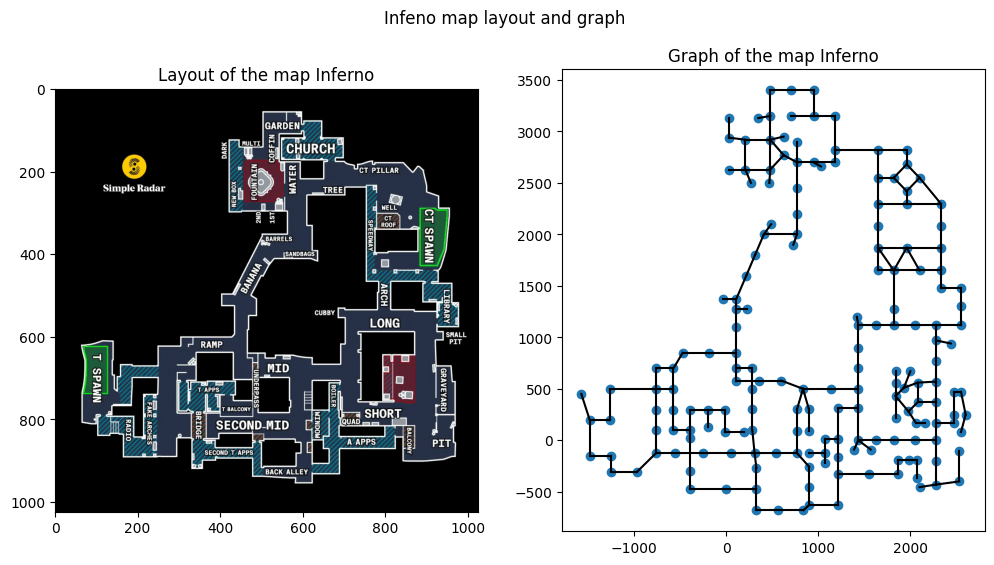

In [35]:
fig, axs = plt.subplots(1,2,figsize=(12,6))

img = mpimg.imread('src/inferno_layout.png')
imgplot = axs[0].imshow(img)
axs[0].set_title("Layout of the map Inferno")

graphnodes = pd.DataFrame(data=dataset[0]['map']['x'].numpy(), columns=['x','y','path'])
graphedges = pd.DataFrame(data=dataset[0]['map','connected_to','map']['edge_index'].numpy().T, columns=['startIdx', 'endIdx'])

axs[1].scatter(graphnodes['x'], graphnodes['y'])
for idx, edge in graphedges.iterrows():
    axs[1].plot([graphnodes.iloc[edge['startIdx']]['x'], graphnodes.iloc[edge['endIdx']]['x']], [graphnodes.iloc[edge['startIdx']]['y'], graphnodes.iloc[edge['endIdx']]['y']], c='black',zorder=1)
axs[1].set_title("Graph of the map Inferno")
plt.suptitle('Infeno map layout and graph')
plt.show()

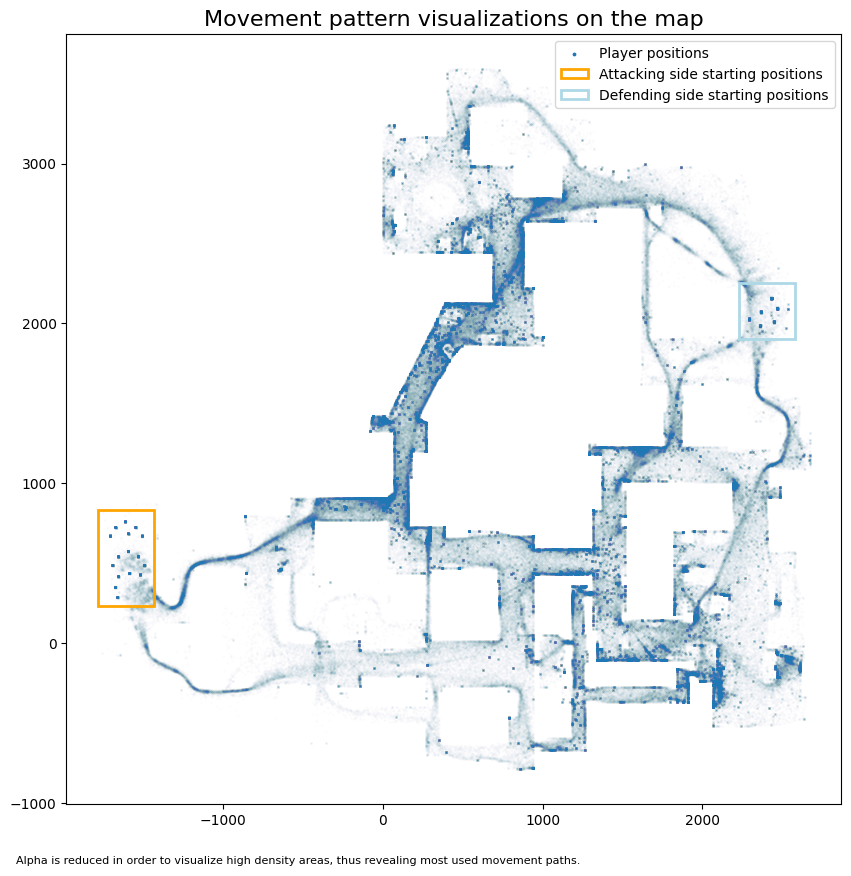

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(0, 850, s=3, label="Player positions")
ax.scatter(df['x'], df['y'], s=0.5, alpha=0.01, c='#1f77b4')
square_t = patches.Rectangle((-1780, 230), 350, 600, edgecolor='orange', facecolor='none', linewidth=2, label="Attacking side starting positions")
ax.add_patch(square_t)
square_ct = patches.Rectangle((2230, 1900), 350, 350, edgecolor='lightblue', facecolor='none', linewidth=2, label="Defending side starting positions")
ax.add_patch(square_ct)
plt.axis('equal')
plt.legend()
ax.set_title('Movement pattern visualizations on the map', fontsize=16)
plt.figtext(0.075, 0.05, 'Alpha is reduced in order to visualize high density areas, thus revealing most used movement paths.', fontsize=8);

Text(0.5, 1.0, 'Movement pattern visualization with heatmap')

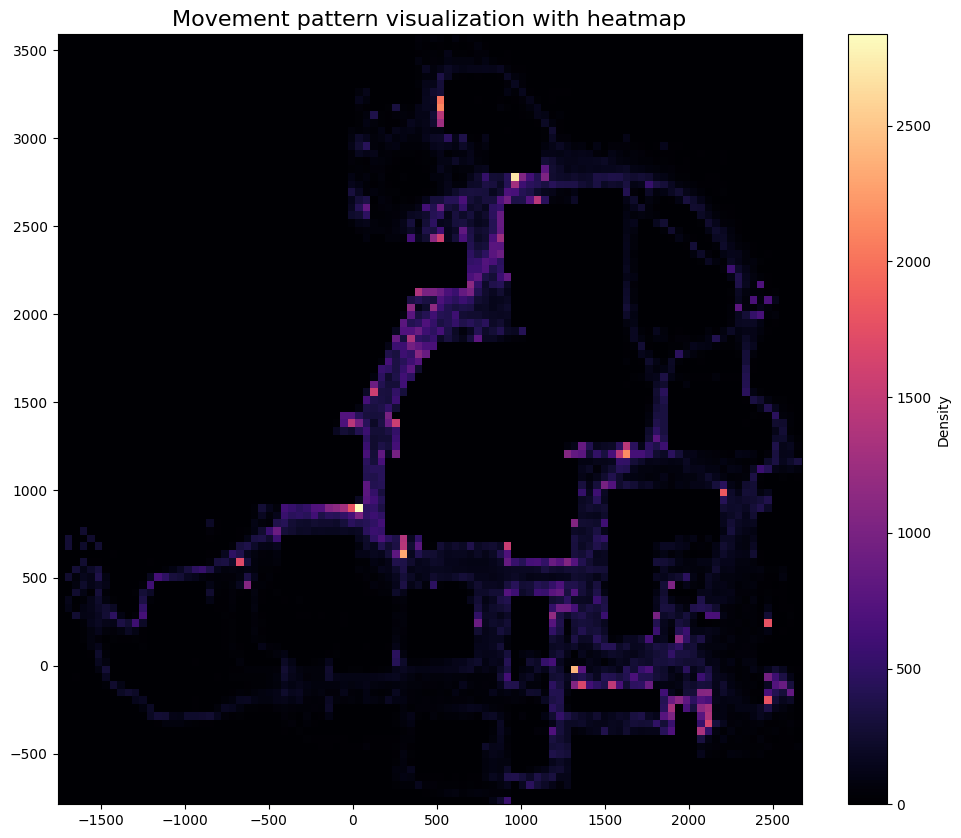

In [6]:
figure = plt.figure(figsize=(12,10))
hb = plt.hist2d(df['x'], df['y'], bins=100,  cmap='magma')
plt.colorbar(hb[3], label='Density')
plt.title('Movement pattern visualization with heatmap', fontsize=16)

## II. Player data

In [43]:
def get_names_stats_datasets():
    # Names dataset
    names = pd.read_csv('../data/player-stats/names.csv')
    names['name'] = names['name'].str.replace("NAF-FLY","NAF")
    names['name'] = names['name'].str.replace("niko","niko-")
    names['one'] = 1
    names['count'] = names.groupby(by='name')['one'].transform('sum')
    del names['one']

    # Stats dataset
    stats = pd.read_csv('../data/player-stats/stats.csv')
    stats['player_name'] = stats['player_name'].str.replace("-", "")
    stats['player_name'] = stats['player_name'].str.replace("niko", "niko-")

    return names.drop_duplicates(), stats

names, stats = get_names_stats_datasets()

In [58]:
names.loc[names['name'].str.contains('ee')]

,name,count,one,lowerName,caseDiff
25,oSee,11,1,osee,1
140,dupreeh,8,1,dupreeh,1
414,saffee,10,1,saffee,1


In [62]:
dropArr = [475, 539, 216, 256, 462, 543, 734, 361, 652]
stats.loc[stats.index.isin(dropArr)]

,player_name,rating_2.0,DPR,KAST,Impact,ADR,KPR,total_kills,HS%,total_deaths,...,weapon_data,clutches_won_1on1,clutches_lost_1on1,clutches_won_1on2,clutches_won_1on3,clutches_won_1on4,clutches_won_1on5,one,lowerName,caseDiff
216,Lucky,1.08,0.63,70.0,1.07,71.8,0.70,7565,40.7,6846,...,"{'kills_awp': '3362', 'kills_ak47': '1341', 'k...",79,67,50,16,1,0,1,lucky,2
256,Lucky,1.10,0.64,71.7,1.07,77.2,0.69,20018,41.6,18516,...,"{'kills_ak47': '6827', 'kills_m4a1': '2724', '...",207,150,110,22,6,0,1,lucky,2
361,steel,1.02,0.69,69.6,1.16,80.0,0.71,11498,45.7,11237,...,"{'kills_ak47': '3258', 'kills_m4a1': '1356', '...",121,68,60,11,2,0,1,steel,2
462,adreN,1.00,0.65,70.9,1.02,76.5,0.67,12259,35.3,11879,...,"{'kills_ak47': '3892', 'kills_awp': '2891', 'k...",150,98,78,22,4,0,1,adren,2
475,ALEX,1.00,0.71,67.5,1.10,76.5,0.70,20286,47.5,20558,...,"{'kills_ak47': '7076', 'kills_m4a1': '3701', '...",173,99,71,19,5,0,1,alex,2
539,AdreN,0.98,0.68,68.5,1.05,75.9,0.67,31342,48.9,31562,...,"{'kills_ak47': '11917', 'kills_m4a1': '5093', ...",282,184,147,38,6,0,1,adren,2
543,roman,0.98,0.69,70.3,1.04,74.1,0.68,17857,54.2,17998,...,"{'kills_ak47': '7757', 'kills_m4a1': '2437', '...",149,142,99,20,3,0,1,roman,2
652,steel,0.95,0.67,70.0,0.97,71.9,0.65,23900,40.8,24692,...,"{'kills_ak47': '9114', 'kills_m4a1': '5601', '...",234,156,122,25,1,1,1,steel,2
734,roman,0.91,0.68,68.3,0.89,69.6,0.62,6787,55.0,7451,...,"{'kills_ak47': '2418', 'kills_m4a1': '1478', '...",77,74,33,10,1,0,1,roman,2


In [54]:
df = names.merge(stats, how='left', left_on='name', right_on='player_name')
df.loc[df['rating_2.0'].isna()].head(20)

,name,count,player_name,rating_2.0,DPR,KAST,Impact,ADR,KPR,total_kills,...,rating_1.0_lan_Career,rating_1.0_major_Career,rating_1.0_data,weapon_data,clutches_won_1on1,clutches_lost_1on1,clutches_won_1on2,clutches_won_1on3,clutches_won_1on4,clutches_won_1on5
4,m0NESY,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,jeorge,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,headtr1ck,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NAF-FLY,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,regali,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,s1n,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Krimbo,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,prosus,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,jL,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,dev1ce,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
